# Assignment 2: CNN architectures {-}

This assignment aims at familiarizing you with training, validating and testing deep neural networks. Here are the BASIC requirements of the assignment:

- Load the data.
- Process, normalize and resize the images.
- Build a CNN architecture of your choice (from this list of models https://www.tensorflow.org/api_docs/python/tf/keras/applications, except the VGG16 as in the demo code). Several ideas for model construction: adjust the cut-off layer position, add various types of neural network layers after the cut-off layer, etc. 
- Train and validate the CNN to perform the image classification task.
- Evaluate the performance of the model on the test set.
- Visualize the model behaviour during the training.

The dataset you will be working on is The CIFAR-10. This dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-assignment2-notebook.ipynb: Jupyter notebook containing source code.
- ./\<Test-accuracy>-\<StudentID>.txt: accuracy on the test, for example if you get 0.8124 accuracy, the name of this file is 08124-2012345.txt. The file content is left empty.

The submission folder is named DL4AI-\<StudentID>-Assignment2 (e.g., DL4AI-2012345-Assigment2) and then compressed with the same name.


    
### Evaluation {-}
Assignment evaluation will be conducted on how you accomplish the assignment requirements. It is a plus if you have modeling steps other than the basic requirements and achieve an excellent model accuracy. In addition, your code should conform to a Python coding convention such as PEP-8.

EXTRA CREDIT: Top-3 submissions achieving the highest test accuracy will be rewarded an extra credit.

### Deadline {-}
Please visit Canvas for details.

In [1]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

#!pip install tensorflow_datasets

# Import libraries
import numpy as np
import tensorflow as tf 
import tensorflow_datasets as tfds
import keras
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Activation, Conv2D
from keras.utils import np_utils
from keras import layers
from keras import Model

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt 

In [2]:
# Get the full dataset (batch_size=-1) in NumPy arrays from the returned tf.Tensor object
cifar10_train = tfds.load(name="cifar10", split=tfds.Split.TRAIN, batch_size=-1 ) 
cifar10_test = tfds.load(name="cifar10", split=tfds.Split.TEST, batch_size=-1)

# Convert tfds dataset to numpy array records
cifar10_train = tfds.as_numpy(cifar10_train) 
cifar10_test = tfds.as_numpy(cifar10_test)

2023-04-19 23:20:56.080070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-19 23:20:56.080398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-19 23:20:56.091913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-19 23:20:56.092204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-19 23:20:56.092467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

# Data processing and model training

In [3]:
# Seperate feature X and label Y
X_train, Y_train = cifar10_train["image"], cifar10_train["label"]
X_test, Y_test = cifar10_test["image"], cifar10_test["label"]
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=99, test_size=0.2)

# Normalize the image data
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

# Specify the input image size and number of classes
img_width, img_height = 32, 32
nb_classes = 10

# Converts a class vector (integers) to binary class matrix to have one-hot encoding label. For example:
# Airplane is [1,0,0,0,0,0,0,0,0,0]
# Automobile is [0,1,0,0,0,0,0,0,0,0]
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_val = np_utils.to_categorical(Y_val, nb_classes) 
Y_test = np_utils.to_categorical(Y_test, nb_classes)

In [4]:
# Add augmentation layer to model
img_augmentation = keras.Sequential(
    [
        layers.RandomRotation(factor=0.3),
        layers.RandomFlip('horizontal'),
        layers.RandomZoom(0.3,0.1),
    ],
    name="img_augmentation",
)

In [5]:
# Build input model
inputs = layers.Input(shape=(img_width, img_height, 3))
# Resize
aug = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (128,128)))(inputs)
# Augmentation
aug = img_augmentation(aug)
# Get MobileNet Model
base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, input_tensor=aug, weights="imagenet", input_shape=(128, 128, 3))

# Freeze the pretrained weights
base_model.trainable = True

base_model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 128, 128, 3)       0         
                                                                 
 img_augmentation (Sequentia  (None, 128, 128, 3)      0         
 l)                                                              
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32) 

In [6]:
# Add dropouts layer after relu layer to prevent overfiting when training all model
def add_dropouts(model, prob=0.2):
    updated_model = tf.keras.models.Sequential()
    a = 0
    for layer in model.layers:
        updated_model.add(layer)
        if 'relu' in layer.name:
            if a % 2 == 0:
              updated_model.add(tf.keras.layers.Dropout(prob))
        a+=1
    return updated_model
dropout_model = add_dropouts(base_model)
dropout_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 128, 128, 3)       0         
                                                                 
 img_augmentation (Sequentia  (None, 128, 128, 3)      0         
 l)                                                              
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       2

In [7]:
# Extract the last layer from third block of MobelNet model
last_layer = dropout_model.get_layer('conv_pw_13_relu').output

In [8]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last_layer) # Convert the last layer to a 1D tensor.
x = Dropout(0.5)(x) # Add a dropout layer with probability 0.5.
x = BatchNormalization()(x)
outputs = Dense(nb_classes, activation='softmax', name = 'pred')(x) # Add a fully connected layer with softmax activation function as the prediction output.

# Build model
model_cifar10 = tf.keras.Model(inputs, outputs)

In [9]:
model_cifar10.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 128, 128, 3)       0         
                                                                 
 img_augmentation (Sequentia  (None, 128, 128, 3)      0         
 l)                                                              
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0     

In [10]:
# Compile the model
model_cifar10.compile(loss='categorical_crossentropy', # Categorical cross-entropy as loss function
              optimizer=tf.keras.optimizers.Adam(), # Optimizer of Adam.
              metrics=['accuracy']) # Metric to evaludate the model performance

In [11]:
# Add Early Stopping for training to prevent overfiting
cm = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Train the model, show training and validation performance
model_training = model_cifar10.fit(X_train, Y_train, epochs=80, batch_size=512, validation_data=(X_val, Y_val), callbacks = [cm])

Epoch 1/80


2023-04-19 23:21:09.237045: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2023-04-19 23:21:13.531173: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-04-19 23:21:13.531251: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-04-19 23:21:13.536317: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


79/79 [==============================] - 62s 633ms/step - loss: 0.9417 - accuracy: 0.6904 - val_loss: 5.5158 - val_accuracy: 0.2805
Epoch 2/80
79/79 [==============================] - 46s 587ms/step - loss: 0.5419 - accuracy: 0.8135 - val_loss: 2.2064 - val_accuracy: 0.5256
Epoch 3/80
79/79 [==============================] - 47s 591ms/step - loss: 0.4494 - accuracy: 0.8464 - val_loss: 0.7069 - val_accuracy: 0.7959
Epoch 4/80
79/79 [==============================] - 47s 591ms/step - loss: 0.3970 - accuracy: 0.8630 - val_loss: 0.5453 - val_accuracy: 0.8162
Epoch 5/80
79/79 [==============================] - 46s 588ms/step - loss: 0.3539 - accuracy: 0.8780 - val_loss: 0.8255 - val_accuracy: 0.7514
Epoch 6/80
79/79 [==============================] - 47s 589ms/step - loss: 0.3191 - accuracy: 0.8889 - val_loss: 0.6390 - val_accuracy: 0.8062
Epoch 7/80
79/79 [==============================] - 47s 591ms/step - loss: 0.2997 - accuracy: 0.8963 - val_loss: 0.5720 - val_accuracy: 0.8276
Epoch 8/80

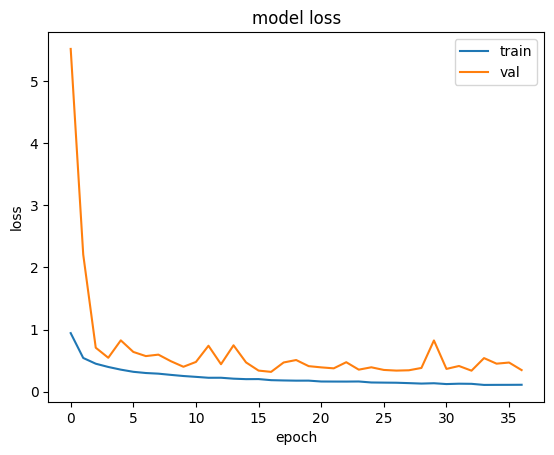

In [12]:
# Visualize the training and validation loss over epochs
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

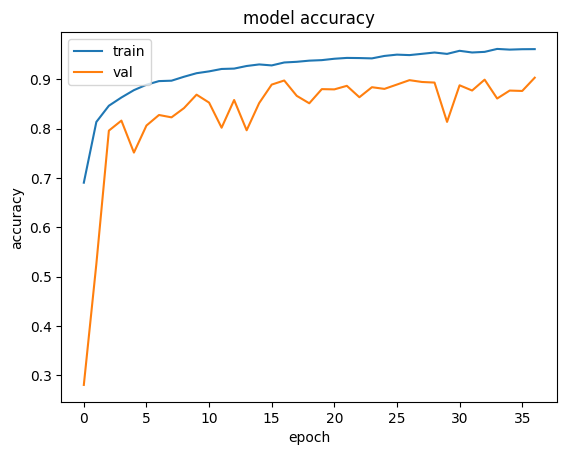

In [13]:
# Visualize the training and validation accuracy over epochs
plt.plot(model_training.history['accuracy'])
plt.plot(model_training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model evaluation

In [14]:
# Evaluate the model prediction on a data sample
pred = model_cifar10.predict(X_test[:1]) # Make prediction on a data sample
print("Model prediction: " + str(pred)) # Model prediction
print("True label: " + str(Y_test[:1])) # True label

Model prediction: [[4.7345653e-01 1.8683566e-05 1.1137857e-01 1.2419232e-02 1.1111741e-02
  8.2971150e-04 3.1850913e-01 7.1176328e-02 4.2716198e-05 1.0572668e-03]]
True label: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [15]:
# Evaluate the model prediction on the entire test set
preds = model_cifar10.predict(X_test) # Make prediction on the entire test set
preds_index = np.argmax(preds, axis=1) # Get the index of maximum class probability of each of the data sample
label_index = np.argmax(Y_test, axis=1) # Get the index of maximum class label

In [16]:
# Compare the predictions with the true labels
comparison_result = np.equal(preds_index, label_index) # Return the comparison result which is an array of True/False.

# Calculate the number of correct predictions (True values in the comparison result array).
correct_preds = comparison_result.sum() # Compute the sum of elements across dimensions of a tensor.

# Show accuracy
print("Number of correct predictions: " + str(correct_preds))
print("Test accuracy: " + str(correct_preds/X_test.shape[0]))

Number of correct predictions: 8915
Test accuracy: 0.8915


In [17]:
model_cifar10.save('checkpoints/mobileNet.h5')
model_cifar10.save_weights('checkpoints/mobileNet_w.h5')

# Model evaluation using built-in Tensorflow function

In [19]:
# Evaluate the model accuracy using the function model.evaluate()
model_eval = model_cifar10.evaluate(X_test, Y_test, batch_size=256)
print("List of metrics" + str(model_cifar10.metrics_names)) # List of possible metrics of the model evaluation, this is the metrics specified in the model.compile().

print("Test loss: " + str(model_eval[0])) # Test loss 
print("Test accuracy: " + str(model_eval[1])) # Test accuracy

40/40 [==============================] - 3s 52ms/step - loss: 0.3989 - accuracy: 0.8915
List of metrics['loss', 'accuracy']
Test loss: 0.39886656403541565
Test accuracy: 0.8914999961853027
